# My Favorite Pet

In [1]:
import os
# import cv2
# import random
import numpy as np
import pandas as pd
# from tqdm import tqdm
# import pathlib
from pathlib import Path
from PIL import Image
# import glob
# import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import random_split
# from torch.utils.data import DataLoader, Dataset, Subset
# from torch.utils.data import random_split, SubsetRandomSampler
# from torchvision import datasets, transforms, models 
# from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor
# from torchvision.utils import make_grid
# from pytorch_lightning import LightningModule
# from pytorch_lightning import Trainer
# import pytorch_lightning as pl
# import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/Users/lin.yang/miniconda3/envs/cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Exploration

In [2]:
data_path = './Data/mammals/'
mammals = [f.name for f in os.scandir(data_path) if f.is_dir()]
# mammals_data_url = [data_url + mammal for mammal in mammals]
# mammals_data_url
mammals

['cat', 'dog', 'bear', 'tiger', 'goat', 'wolf', 'horse', 'lion', 'elephant']

### Separate dog data

In [3]:
dog_root = data_path + 'dog/'
dog_url = [dog_root+dog for dog in os.listdir(dog_root)]
dog_url.remove(dog_root + '.DS_Store')
dog_data = [Image.open(dog) for dog in dog_url]

## Example of how to read the image as numpy array

In [4]:
dog_1 = Image.open(dog_url[1])
# "thumbnail" is to shrink the image wihile keeping the aspect ratio
dog_1.thumbnail((100, 100))
dog_1.show()

In [5]:
# "reduced" is to shrink the image resolution by dividing the given value
dog_1_re = dog_1.reduce((10, 10))
dog_1_re.show()

In [6]:
dog_0 = Image.open(dog_url[0])
# "resize" is to shrink the image to a given size
dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)
dog_0_r.show()

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_65357/305650333.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)


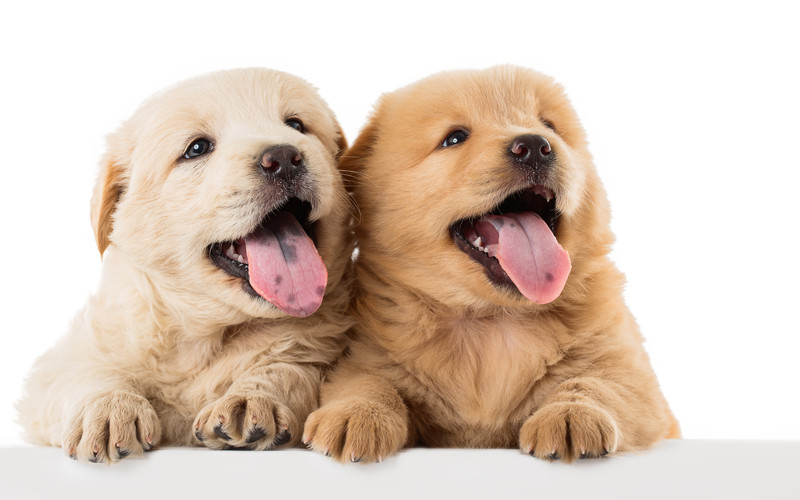

In [7]:
Image.open(dog_url[1])

# Data Preparation

### Loading data into a pandas data frame with one column of file paths and one column of labels

In [8]:
direc = Path('./Data/mammals')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,Data/mammals/tiger/00000048.jpg,tiger
1,Data/mammals/dog/00000023.jpg,dog
2,Data/mammals/elephant/00000065.jpg,elephant
3,Data/mammals/dog/00000024.jpg,dog
4,Data/mammals/horse/00000073.jpg,horse


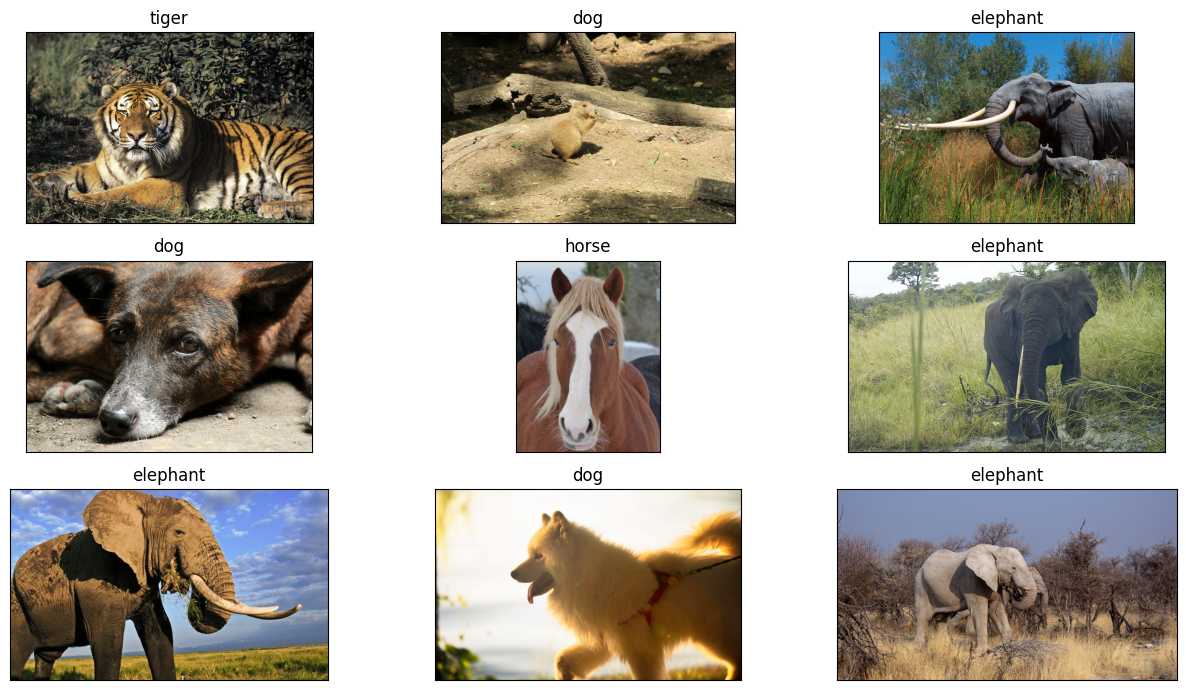

In [9]:
f, a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

### Split training data

In [18]:
def divide_data(img_df, dog_or_cat='dog'):
    if dog_or_cat not in ['dog', 'cat']:
        raise ValueError("Invalid value for dog_or_cat. It should be either 'dog' or 'cat'.")
    main_animal_df = img_df[img_df.Labels==dog_or_cat]
    half = img_df.shape[0] // 2
    if dog_or_cat == 'dog':
        slice_animals = slice(0, half)
    else:
        slice_animals = slice(half, -1)
    all_animals_df = img_df[~img_df.Labels.isin(['dog', 'cat'])][slice_animals].sample(n = main_animal_df.shape[0], random_state=42)
    # all_animals_df = img_df[~img_df.Labels.isin(['dog', 'cat'])].sample(n = main_animal_df.shape[0], random_state=42)[slice_animals]
    df = pd.concat([main_animal_df, all_animals_df]).sample(frac = 1, random_state=42)
    df['y'] = df.Labels == dog_or_cat
    return df

In [31]:
dog_train = divide_data(img_df, dog_or_cat='dog')
print(type(dog_train))
print('Training set size:', dog_train.shape)
print('Training set statistics', dog_train.Labels.value_counts())
print(dog_train.y.value_counts())
dog_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics Labels
dog         95
elephant    17
wolf        16
lion        15
tiger       14
horse       12
goat        11
bear        10
Name: count, dtype: int64
y
False    95
True     95
Name: count, dtype: int64


,FilePaths,Labels,y
5,Data/mammals/elephant/00000027.jpg,elephant,False
84,Data/mammals/lion/00000060.jpg,lion,False
486,Data/mammals/goat/00000033.jpg,goat,False
555,Data/mammals/dog/00000054.jpg,dog,True
489,Data/mammals/horse/00000000.jpg,horse,False


## Resize images by padding

In [32]:
def resize_image(pil_img, new_width=100, new_height=100, color='white'):
    right = left = top = bottom = 0
    width, height = pil_img.size
    if width > new_width and height > new_height:
        return pil_img.resize((100, 100))
    elif width < new_width:
        w = new_width - width
        left = w //2
        right = w - left
    elif height < new_height:
        h = new_height - height
        top = h //2
        bottom = h - top
        
    # new_width = width + right + left
    # new_height = height + top + bottom
    img_pad = Image.new(pil_img.mode, (new_width, new_height), color)
    img_pad.paste(pil_img, (left, top), mask=pil_img)
    return img_pad

In [33]:
# pass all the input samples to the a new pandas.DataFrame where the first column is the image matrix and the second column is the labels the third column is the target binary values
# Resize the images, suppose the size of every given image is greater than 100 x 100
def read_image_matrix(img_path, new_size=(100, 100)):
    # read the image path fron the first column of the dataframe then read the image as a matrix
    try:
        img = Image.open(img_path)
        img_resize = img.resize(size=new_size)
        img_matrix = np.array(img_resize)
        return img_matrix
    except:
        return None

dog_train['Matrix'] = dog_train['FilePaths'].apply(read_image_matrix)

In [35]:
dog_train.head()

,FilePaths,Labels,y,Matrix
5,Data/mammals/elephant/00000027.jpg,elephant,False,"[[[249, 253, 255], [249, 253, 255], [250, 253,..."
84,Data/mammals/lion/00000060.jpg,lion,False,"[[[253, 253, 249], [254, 254, 250], [254, 254,..."
486,Data/mammals/goat/00000033.jpg,goat,False,"[[[200, 200, 198], [205, 205, 203], [208, 208,..."
555,Data/mammals/dog/00000054.jpg,dog,True,"[[[46, 39, 49], [85, 74, 83], [154, 140, 168],..."
489,Data/mammals/horse/00000000.jpg,horse,False,"[[[160, 174, 186], [85, 105, 107], [100, 133, ..."


In [53]:
i = 0
for img in dog_train['Matrix']:
    if np.array(img).shape not in [(100, 100, 3)]:
        i += 1

print(i)

4


In [55]:
# Clean the data by removing the damaged images
dog_train = dog_train[dog_train['Matrix'].apply(lambda x: np.array(x).shape == (100, 100, 3))]
dog_train.reset_index(drop=True, inplace=True)

In [56]:
dog_img_mat = pd.DataFrame({'image_matrix': dog_train['Matrix'], 'label': dog_train['y']})
dog_img_mat['label'] = dog_img_mat['label'].astype(int)
dog_img_mat.head()

,image_matrix,label
0,"[[[249, 253, 255], [249, 253, 255], [250, 253,...",0
1,"[[[253, 253, 249], [254, 254, 250], [254, 254,...",0
2,"[[[200, 200, 198], [205, 205, 203], [208, 208,...",0
3,"[[[46, 39, 49], [85, 74, 83], [154, 140, 168],...",1
4,"[[[160, 174, 186], [85, 105, 107], [100, 133, ...",0


In [57]:
# check the statistics
print('Statistics: ', dog_img_mat.label.value_counts())
print('Size of processed images: ', dog_img_mat.iloc[1]['image_matrix'].shape)
print('An image matrix example: ', dog_img_mat.iloc[1]['image_matrix'])

Statistics:  label
0    93
1    93
Name: count, dtype: int64
Size of processed images:  (100, 100, 3)
An image matrix example:  [[[253 253 249]
  [254 254 250]
  [254 254 253]
  ...
  [255 255 255]
  [254 254 253]
  [253 253 251]]

 [[254 254 251]
  [254 254 252]
  [255 255 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 254]]

 [[254 254 253]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 254]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 63  57  51]
  [ 67  59  52]
  [117 107  99]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 67  59  53]
  [ 78  68  60]
  [116 107  99]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 63  56  47]
  [ 80  69  59]
  [111 101  93]]]


one dog image and one non-dog image are removed due to damage reason

## Train a Convolutional Neural Network for Classification

### Prepare the training data

In [58]:
# dog_img_mat['image_matrix'].fillna(255)
X_train = np.stack(dog_img_mat['image_matrix'].values)
X_train = X_train.astype('float32') / 255.0
X_train = X_train.reshape(-1, 100, 100, 3)

y_train = dog_img_mat['label'].values

In [62]:
# Split the data set into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Build CNN model

In [71]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [72]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 76832)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                4917312   
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4918273 (18.76 MB)
Trainable params: 4918273 (18.76 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [73]:
model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30


2023-06-18 18:24:26.678326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 51ms/step - loss: 23.0130 - accuracy: 0.4459
Epoch 2/30
5/5 [==============================] - 0s 28ms/step - loss: 12.5376 - accuracy: 0.4865
Epoch 3/30
5/5 [==============================] - 0s 28ms/step - loss: 5.9188 - accuracy: 0.4932
Epoch 4/30
5/5 [==============================] - 0s 34ms/step - loss: 5.2804 - accuracy: 0.5135
Epoch 5/30
5/5 [==============================] - 0s 27ms/step - loss: 2.1929 - accuracy: 0.5338
Epoch 6/30
5/5 [==============================] - 0s 25ms/step - loss: 2.2979 - accuracy: 0.5405
Epoch 7/30
5/5 [==============================] - 0s 26ms/step - loss: 1.2371 - accuracy: 0.5676
Epoch 8/30
5/5 [==============================] - 0s 25ms/step - loss: 1.0306 - accuracy: 0.5270
Epoch 9/30
5/5 [==============================] - 0s 35ms/step - loss: 0.8933 - accuracy: 0.6351
Epoch 10/30
5/5 [==============================] - 0s 27ms/step - loss: 0.8719 - accuracy: 0.6149
Epoch 11/30
5/5 [=====================

In [74]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

2/2 [==============================] - 0s 40ms/step - loss: 0.7983 - accuracy: 0.5789
Loss:  0.7982843518257141
Accuracy:  0.5789473652839661


2023-06-18 18:24:33.476764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
